## Analysis

In [1]:
import numpy as np
import pandas as pd
#import pyfolio as pf
import datetime as dt
import time
import sys
import os

import multiprocessing as mp
from multiprocessing import cpu_count

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
np.random.seed(42)
%matplotlib inline

In [2]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [3]:
import seaborn as sns

In [4]:
indicators_folder = os.path.join(os.getcwd(), "data/7_Indicators")


In [9]:
def get_rf(X, y, rand=False):

    ### Balance classes

    # Split data into training, validation and test sets
    #X_training_validation = X['2011-09-01':'2018-01-01']
    #y_training_validation = y['2011-09-01':'2018-01-01']
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.15, shuffle=False)

    train_df = pd.concat([y_train, X_train], axis=1, join='inner')
    # train_df['bin'].value_counts()

    # Upsample the training data to have a 50 - 50 split
    # https://elitedatascience.com/imbalanced-classes
    majority = train_df[train_df['bin'] == 0]
    minority = train_df[train_df['bin'] == 1]

    if len(majority) < len(minority):
        majority, minority = minority, majority

    new_minority = resample(minority, 
                       replace=True,     # sample with replacement
                       n_samples=majority.shape[0],    # to match majority class
                       random_state=42)

    train_df = pd.concat([majority, new_minority])
    train_df = shuffle(train_df, random_state=42)

    # train_df['bin'].value_counts()

    # Create training data
    y_train = train_df['bin']
    X_train= train_df.loc[:, train_df.columns != 'bin']

    ### Fit a model

    parameters = {'max_depth':[2, 3, 4, 5, 7],
                  'n_estimators':[1, 10, 25, 50, 100, 256, 512],
                  'random_state':[42]}

    def perform_grid_search(X_data, y_data):
        rf = RandomForestClassifier(criterion='entropy')

        clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=-1)
        


        clf.fit(X_data, y_data)

        # print(clf.cv_results_['mean_test_score'])

        return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

    def perform_rand_search(X_data, y_data):
        param_distribs = {'max_depth': randint(low=2, high=8),
                      'n_estimators': randint(low=1, high=500),
                    }

        rf = RandomForestClassifier(criterion='entropy')

        clf = RandomizedSearchCV(rf, param_distributions=param_distribs, n_iter=10,
                                            cv=4, scoring='roc_auc', n_jobs=-1,
                                            random_state=42)


        clf.fit(X_data, y_data)

        # print(clf.cv_results_['mean_test_score'])

        return clf.best_params_['n_estimators'], clf.best_params_['max_depth']
    
    
    # extract parameters
    n_estimator, depth = perform_grid_search(X_train, y_train) if not rand else perform_rand_search(X_train, y_train)
    c_random_state = 42
    # print(n_estimator, depth, c_random_state)

    # Refit a new model with best params, so we can see feature importance
    rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                                criterion='entropy', random_state=c_random_state,
                               n_jobs=-1)

    t = rf.fit(X_train, y_train.values.ravel())

    # print(t)

    #### Training Metrics

    # Performance Metrics
    y_pred_rf = rf.predict_proba(X_train)[:, 1]
    y_pred = rf.predict(X_train)
    fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)

    
    return rf, fpr_rf, tpr_rf, X_validate, y_validate, classification_report(y_train, y_pred, output_dict=True), accuracy_score(y_train, y_pred)

In [11]:
res = pd.DataFrame(columns=['symbol', 'vert_barrier', 'min_ret', 'fast_slow',
                            'f1 train 0', 'f1 train 1', 'accuracy train',
                           'f1 test 0', 'f1 test 1',
                            'precision test 1', 'recall test 1', 'accuracy test'])

In [34]:
for i, file in enumerate(os.listdir(indicators_folder)):
    if file.startswith('.'):
        continue
        
    if file in res.index:
        continue
        
    if file == 'ALRS_1_30.0_50-200_ind.csv':
        continue
    
    data = file.split("_")
    if data[3] == 'indicators.csv':
        continue
    
    file_path = os.path.join(indicators_folder, file)
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    df.dropna(axis=0, inplace=True)
    
    y = df['bin'].copy()
    X = df[['side', 'log_ret', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5',
       'volatility_50', 'volatility_31', 'volatility_15', 'autocorr_1',
       'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5', 'log_t1',
       'log_t2', 'log_t3', 'log_t4', 'log_t5']].copy()
    
    
    rf, fpr_rf, tpr_rf, X_validate, y_validate, conf_mat, acc_score = get_rf(X, y, rand=True)
    
    
    # Meta-label
    # Performance Metrics
    y_pred_rf = rf.predict_proba(X_validate)[:, 1]
    y_pred = rf.predict(X_validate)
    # fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
    a = classification_report(y_validate, y_pred, output_dict=True)
    acc_score_test = accuracy_score(y_validate, y_pred)
    
    res.loc[file] = [data[0], data[1], data[2], data[3],
                     conf_mat['1.0']['f1-score'], conf_mat['0.0']['f1-score'], acc_score,
                     a['1.0']['f1-score'], a['0.0']['f1-score'],
                     a['1.0']['precision'], a['1.0']['recall'], acc_score_test
                    ]
    print(i, end="\r")

In [35]:
res.to_csv('res.csv')

In [37]:
res.head()

,symbol,vert_barrier,min_ret,fast_slow,f1 train 0,f1 train 1,accuracy train,f1 test 0,f1 test 1,precision test 1,recall test 1,accuracy test
GMKN_3_1.0_20-50_ind.csv,GMKN,3,1.0,20-50,0.779643,0.762785,0.771525,0.508227,0.430085,0.385576,0.745308,0.472031
LKOH_10_1.0_50-200_ind.csv,LKOH,10,1.0,50-200,0.801249,0.749821,0.778481,0.637579,0.299320,0.524913,0.811828,0.522263
SBER_7_1.0_50-200_ind.csv,SBER,7,1.0,50-200,0.782810,0.786674,0.784759,0.578199,0.435995,0.510888,0.665939,0.517354
MGNT_7_30.0_20-50_ind.csv,MGNT,7,30.0,20-50,0.976190,0.977273,0.976744,0.457831,0.628099,0.351852,0.655172,0.558824
VTBR_10_30.0_50-200_ind.csv,VTBR,10,30.0,50-200,0.945677,0.947212,0.946456,0.365482,0.481328,0.283465,0.514286,0.429224


In [38]:
df2 = res.set_index(['symbol', 'vert_barrier', 'min_ret', 'fast_slow'])

In [40]:
df4 = df2.groupby(level=[0, 1, 2]).median()

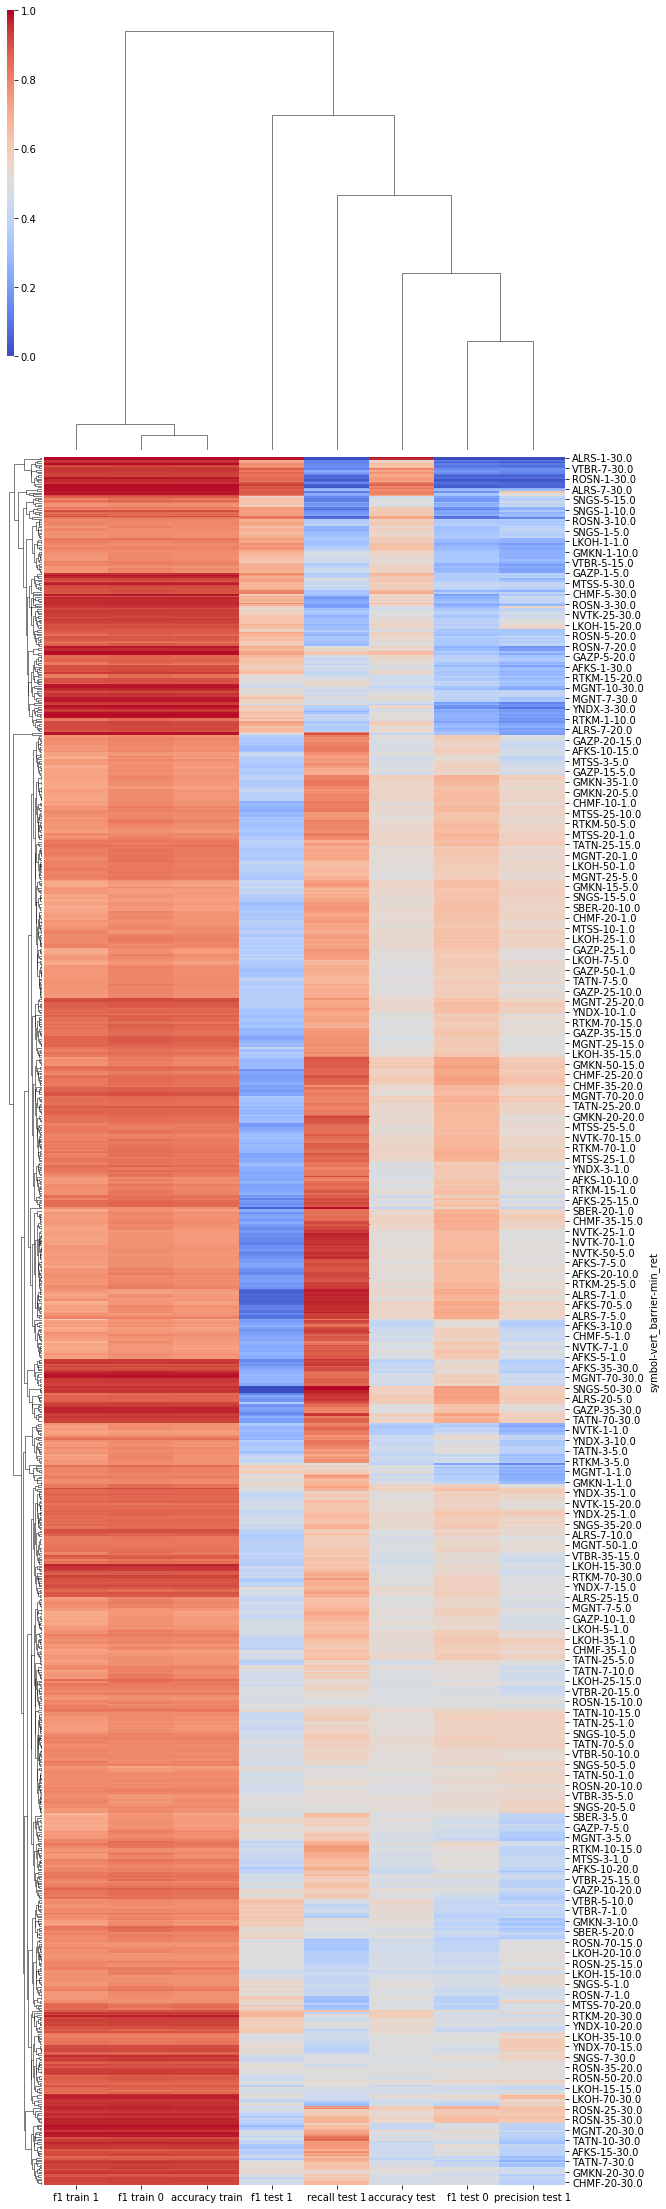

In [43]:
sns.clustermap(df4, cmap='coolwarm', figsize=(10, 40));

In [44]:
df3 = df2.groupby(level=[1, 2, 3]).median().sort_values(by=['f1 test 1'], ascending=False).head(50)
df3

f1 train 0  f1 train 1  accuracy train  \
vert_barrier min_ret fast_slow                                           
1            30.0    20-50        0.970391    0.969361        0.969565   
                     50-200       0.979009    0.978541        0.978778   
3            30.0    20-50        0.945441    0.944900        0.945389   
                     50-200       0.957601    0.954832        0.956260   
5            30.0    20-50        0.942582    0.939197        0.940954   
1            10.0    20-50        0.794419    0.784734        0.783639   
                     50-200       0.806357    0.793230        0.795259   
5            30.0    50-200       0.963224    0.963688        0.963458   
7            30.0    20-50        0.939765    0.938833        0.939032   
                     50-200       0.961344    0.959925        0.960674   
5            20.0    20-50        0.867141    0.846996        0.856894   
3            10.0    50-200       0.799336    0.783243        0.793216   
10           30.0    20-50        0.938423    0.934100        0.936335   
5            15.0    20-50        0.816377    0.796848        0.802241   
7            20.0    20-50        0.862461    0.839420        0.850820   
3            10.0    20-50        0.798282    0.772470        0.787756   
1            5.0     50-200       0.802227    0.790702        0.793827   
10           30.0    50-200       0.946745    0.946520        0.946647   
             20.0    20-50        0.866728    0.855945        0.862558   
1            5.0     20-50        0.781029    0.769922        0.773875   
5            10.0    50-200       0.795084    0.773433        0.779233   
1            1.0     20-50        0.779162    0.768629        0.771832   
20           30.0    20-50        0.938768    0.936379        0.937326   
1            1.0     50-200       0.801919    0.782413        0.788191   
7            15.0    20-50        0.823399    0.807493        0.816668   
5            10.0    20-50        0.787558    0.753979        0.773860   
15           30.0    20-50        0.940283    0.937260        0.938812   
7            10.0    20-50        0.795990    0.760575        0.776082   
                     50-200       0.786870    0.759664        0.772695   
3            1.0     20-50        0.776180    0.750083        0.763021   
15           20.0    20-50        0.862213    0.859059        0.858760   
5            5.0     50-200       0.784771    0.764992        0.781658   
3            5.0     50-200       0.784492    0.768005        0.779471   
10           15.0    20-50        0.818836    0.797403        0.811532   
15           30.0    50-200       0.952709    0.951826        0.952325   
25           30.0    20-50        0.941864    0.940479        0.941202   
10           10.0    50-200       0.796709    0.778809        0.790683   
3            5.0     20-50        0.776155    0.750888        0.767307   
             1.0     50-200       0.783280    0.758598        0.772523   
10           10.0    20-50        0.787325    0.754432        0.770911   
7            1.0     50-200       0.790359    0.769644        0.783610   
             5.0     50-200       0.787267    0.776469        0.779797   
5            1.0     50-200       0.786563    0.758987        0.780106   
50           10.0    20-50        0.798132    0.776337        0.790524   
35           30.0    20-50        0.947296    0.945102        0.946221   
10           5.0     50-200       0.785991    0.777805        0.780534   
35           10.0    20-50        0.799868    0.776722        0.789391   
50           30.0    20-50        0.944764    0.943704        0.944146   
70           10.0    20-50        0.784512    0.779771        0.777976   
20           10.0    20-50        0.797001    0.780096        0.787899   

                                f1 test 0  f1 test 1  precision test 1  \
vert_barrier min_ret fast_slow                                           
1            30.0    20-50       0.